In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

In [97]:
EPISODES = 300

In [101]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 1e-3
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        
        # replay memory : 2000
        self.memory = deque(maxlen=2000)
        
        # prediction model and target model
        # DQN이기때문에 network분리
        self.prediction_model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, kernel_initializer='he_uniform'))
        model.summary()
        model.compile(optimizer=Adam(lr=self.learning_rate), loss='mse')
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.prediction_model.get_weights())
        
    def get_action(self, state): # epsilon greedy selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.prediction_model.predict(state)
            return np.argmax(q_value[0])
        
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def train_model(self):
        if self.epsilon > self.epsilon_min: # epsilon decaying
            self.epsilon *= self.epsilon_decay
        
        # random uniform sampling from replay buffer(memory)
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
        
        # 처음 시작할때...fit도 안한상태에서 predict가 되나?
        target = self.prediction_model.predict(states) # Q(s,a) setting
        target_val = self.target_model.predict(next_states) # Q(s',a') setting
        
        # target updating
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i] = rewards[i] + self.discount_factor*(np.max(target_val[i]))
        
        self.prediction_model.fit(states, target, epochs=1, batch_size=self.batch_size, verbose=0)

In [102]:
# let's go
env = gym.make('CartPole-v1')

In [103]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print("state size : ",state_size)
print("action_size : ", action_size)

agent = DQNAgent(state_size, action_size)

state size :  4
action_size :  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_11 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_14 (Dense)             (None, 24)                600       
_____________________________________________

In [105]:
from IPython.display import clear_output

episode: 299   score: 30.0   memory length: 2000   epsilon: 0.009998671593271896


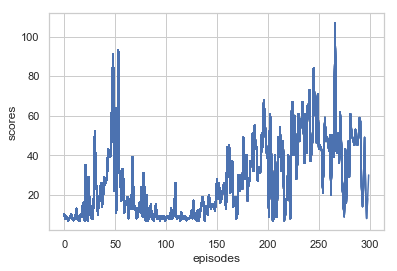

In [106]:
scores, episodes = [], []

for episode in range(EPISODES):
    done = False
    score = 0
    # env initialize
    state = env.reset()
    state = state.reshape(1,-1)
    
    while not done:
        if agent.render: # False로 초기화시켜놨었음
            env.render()
            
        action = agent.get_action(state)
        
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape(1,-1)
        reward = reward if not done or score == 499 else -100
        
        agent.append_sample(state, action, reward, next_state, done)
        
        if len(agent.memory) > agent.train_start:
            agent.train_model()
        
        score += reward
        state = next_state
        
        if done: # 한 episode 끝남
            # target 가중치 업데이트
            agent.update_target_model()
            
            score = score if score == 500 else score + 100
            # 에피소드마다 학습 결과 출력
            scores.append(score)
            episodes.append(episode)
            pylab.plot(episodes, scores, 'b')
            pylab.xlabel("episodes")
            pylab.ylabel("scores")
            pylab.savefig("./save_graph/cartpole_dqn.png")
            clear_output()
            print("episode:", episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.model.save_weights("./save_model/cartpole_dqn.h5")
                sys.exit()
